# Processing and narrating a video with GPT-4.1-mini's visual capabilities and GPT-4o TTS API

This notebook demonstrates how to use GPT's visual capabilities with a video. Although GPT-4.1-mini doesn't take videos as input directly, we can use vision and the 1M token context window to describe the static frames of a whole video at once. We'll walk through two examples:

1. Using GPT-4.1-mini to get a description of a video
2. Generating a voiceover for a video with GPT-4o TTS API


In [1]:
from IPython.display import display, Image, Audio

import cv2  # We're using OpenCV to read video, to install !pip install opencv-python
import base64
import time
from openai import OpenAI
import os

client = OpenAI(api_key=os.environ.get("OPENAI_API_KEY", "<your OpenAI API key if not set as env var>"))

## 1. Using GPT's visual capabilities to get a description of a video


First, we use OpenCV to extract frames from a nature [video](https://www.youtube.com/watch?v=kQ_7GtE529M) containing bisons and wolves:


In [2]:
video = cv2.VideoCapture("data/bison.mp4")

base64Frames = []
while video.isOpened():
    success, frame = video.read()
    if not success:
        break
    _, buffer = cv2.imencode(".jpg", frame)
    base64Frames.append(base64.b64encode(buffer).decode("utf-8"))

video.release()
print(len(base64Frames), "frames read.")

618 frames read.


Display frames to make sure we've read them in correctly:


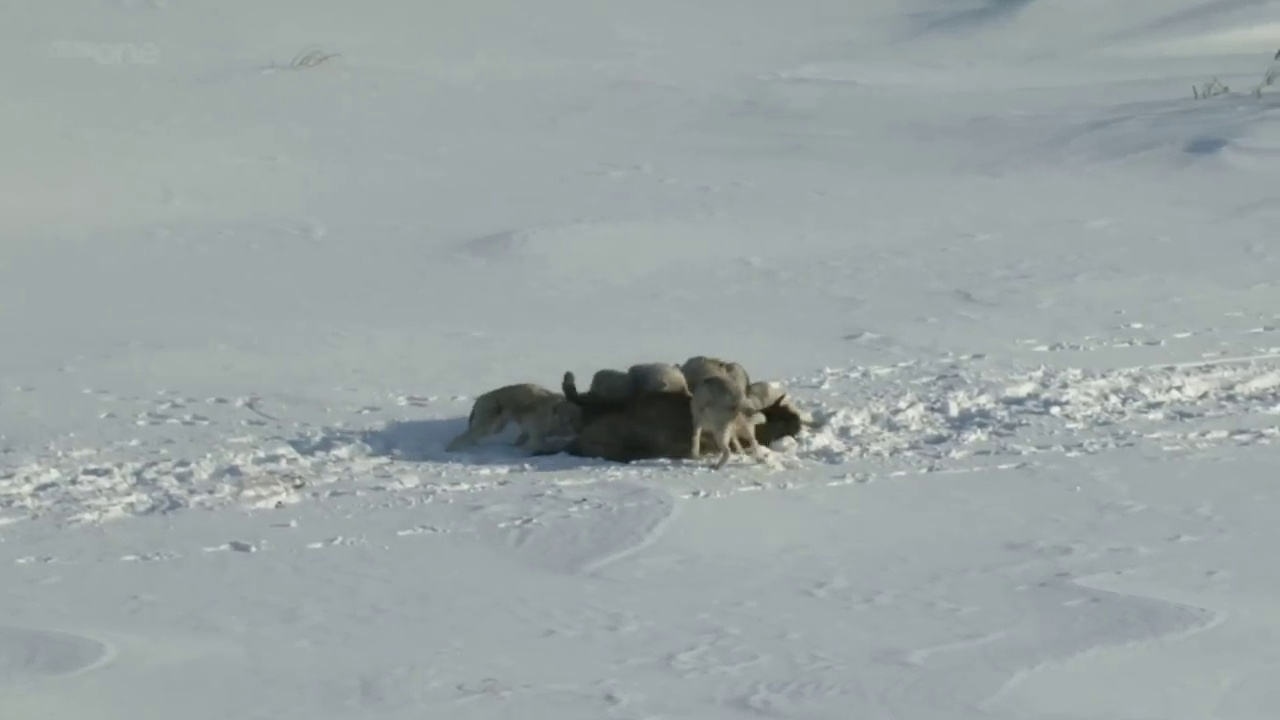

In [3]:
display_handle = display(None, display_id=True)
for img in base64Frames:
    display_handle.update(Image(data=base64.b64decode(img.encode("utf-8"))))
    time.sleep(0.025)

Once we have the video frames, we craft our prompt and send a request to GPT (Note that we don't need to send every frame for GPT to understand what's going on):


In [4]:
response = client.responses.create(
    model="gpt-4.1-mini",
    input=[
        {
            "role": "user",
            "content": [
                {
                    "type": "input_text",
                    "text": (
                        "These are frames from a video that I want to upload. Generate a compelling description that I can upload along with the video."
                    )
                },
                *[
                    {
                        "type": "input_image",
                        "image_url": f"data:image/jpeg;base64,{frame}"
                    }
                    for frame in base64Frames[0::25]
                ]
            ]
        }
    ],
)

print(response.output_text)

Witness the raw power and strategy of nature in this intense wildlife encounter captured in stunning detail. A determined pack of wolves surrounds a lone bison on a snowy plain, showcasing the relentless dynamics of predator and prey in the wild. As the wolves close in, the bison stands its ground amidst the swirling snow, illustrating a gripping battle for survival. This rare footage offers an up-close look at the resilience and instincts that govern life in the animal kingdom, making it a must-watch for nature enthusiasts and wildlife lovers alike. Experience the drama, tension, and beauty of this extraordinary moment frozen in time.


## 2. Generating a voiceover for a video with GPT-4.1 and the GPT-4o TTS API


Let's create a voiceover for this video in the style of David Attenborough. Using the same video frames we prompt GPT to give us a short script:


In [5]:
result = client.responses.create(
    model="gpt-4.1-mini",
    input=[
        {
            "role": "user",
            "content": [
                {
                    "type": "input_text",
                    "text": (
                        "These are frames of a video. Create a short voiceover script in the style of David Attenborough. Only include the narration."
                    )
                },
                *[
                    {
                        "type": "input_image",
                        "image_url": f"data:image/jpeg;base64,{frame}"
                    }
                    for frame in base64Frames[0::25]
                ]
            ]
        }
    ]
)

print(result.output_text)

In the frozen expanse of the winter landscape, a coordinated pack of wolves moves with calculated precision. Their target, a lone bison, is powerful but vulnerable when isolated. The wolves encircle their prey, their numbers overwhelming, displaying the brutal reality of survival in the wild. As the bison struggles to break free, reinforcements from the herd arrive just in time, charging into the pack. A dramatic clash unfolds, where strength meets strategy in the perpetual battle for life. Here, in the heart of nature’s harshest conditions, every moment is a testament to endurance and the delicate balance of predator and prey.


Now, we can work with the GPT-4o TTS model and provide it a set of instructions on how the voice should sound. You can play around with the voice models and instructers at [OpenAI.fm](openai.fm). We can then pass in the script we generated above with GPT-4.1-mini and generate audio of the voiceover:


In [6]:
instructions = """
Voice Affect: Calm, measured, and warmly engaging; convey awe and quiet reverence for the natural world.

Tone: Inquisitive and insightful, with a gentle sense of wonder and deep respect for the subject matter.

Pacing: Even and steady, with slight lifts in rhythm when introducing a new species or unexpected behavior; natural pauses to allow the viewer to absorb visuals.

Emotion: Subtly emotive—imbued with curiosity, empathy, and admiration without becoming sentimental or overly dramatic.

Emphasis: Highlight scientific and descriptive language (“delicate wings shimmer in the sunlight,” “a symphony of unseen life,” “ancient rituals played out beneath the canopy”) to enrich imagery and understanding.

Pronunciation: Clear and articulate, with precise enunciation and slightly rounded vowels to ensure accessibility and authority.

Pauses: Insert thoughtful pauses before introducing key facts or transitions (“And then... with a sudden rustle...”), allowing space for anticipation and reflection.
"""

audio_response = response = client.audio.speech.create(
  model="gpt-4o-mini-tts",
  voice="echo",
  instructions=instructions,
  input=result.output_text,
  response_format="wav"
)

audio_bytes = audio_response.content
Audio(data=audio_bytes)